<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-ridge?scriptVersionId=233775235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ydf scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"

    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    metric = "RMSE"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, X_original=None, y_original=None):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, oof_preds)
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):                       
        oof_preds = np.zeros(X.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
                
            model = clone(self.model)
            model.fit(X_train, y_train)

            oof_preds[val_idx] = model.predict(X_val)
                
            del X_train, y_train, X_val, y_val
            gc.collect() 
            
        return root_mean_squared_error(y, oof_preds)
        
    def _save_results(self, oof_preds, test_preds, cv_score):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            model_name = self.model.__class__.__name__.lower().replace("regressor", "")
            if model_name == "lgbm":
                model_name = "lgbm-" + self.model.boosting_type
            
            if model_name == "bagging":
                model_name = "keras-ann"
            
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            joblib.dump(oof_preds, f"oof/{model_name}/{model_name}_oof_preds_{cv_score:.6f}.pkl")
            joblib.dump(test_preds, f"oof/{model_name}/{model_name}_test_preds_{cv_score:.6f}.pkl")
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=200), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=200
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=200, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
histgb_params = {
    "categorical_features": "from_dtype",
    "l2_regularization": 67.18469453204166,
    "learning_rate": 0.010608367366279405,
    "max_depth": 144,
    "max_features": 0.4821945354902636,
    "max_iter": 2900,
    "max_leaf_nodes": 476,
    "min_samples_leaf": 113,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.35666189554833105,
    "learning_rate": 0.0712803646567931,
    "min_child_samples": 9,
    "min_child_weight": 0.698059594562524,
    "n_estimators": 8000,
    "n_jobs": -1,
    "num_leaves": 99,
    "random_state": 42,
    "reg_alpha": 2.541398781620041,
    "reg_lambda": 5.213846904277453,
    "subsample": 0.8293320429289611,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.3512713278037154,
    "learning_rate": 0.027061280969181176,
    "min_child_samples": 20,
    "min_child_weight": 0.3508926741412963,
    "n_estimators": 8000,
    "n_jobs": -1,
    "num_leaves": 100,
    "random_state": 42,
    "reg_alpha": 8.375922358757403,
    "reg_lambda": 12.664651282936102,
    "subsample": 0.31158073770007033,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8967283343135344,
    "colsample_bynode": 0.8140988171544171,
    "colsample_bytree": 0.4140482432316289,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 9.953199407492168,
    "learning_rate": 0.02734465404229683,
    "max_depth": 68,
    "max_leaves": 94,
    "min_child_weight": 48,
    "n_estimators": 8000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 4.004060065510384,
    "reg_lambda": 13.84439219108794,
    "subsample": 0.9798109009978414,
    "verbosity": 0
}

cb_params = {
    "border_count": 224,
    "colsample_bylevel": 0.9988155629450016,
    "depth": 7,
    "eval_metric": "RMSE",
    "iterations": 8000,
    "l2_leaf_reg": 1.766831546670914,
    "learning_rate": 0.08309498208599289,
    "min_child_samples": 116,
    "random_state": 42,
    "random_strength": 0.9431662515134898,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [7]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [8]:
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, X_original, y_original)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 12.778946
--- Fold 2 - RMSE: 12.849381
--- Fold 3 - RMSE: 12.840857
--- Fold 4 - RMSE: 12.837981
--- Fold 5 - RMSE: 12.822142

------ Overall RMSE: 12.825900 - Average RMSE: 12.825861


## LightGBM (gbdt)

In [9]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 12.9486	valid_0's l2: 167.667
[400]	valid_0's rmse: 12.9093	valid_0's l2: 166.649
[600]	valid_0's rmse: 12.8811	valid_0's l2: 165.923
[800]	valid_0's rmse: 12.8656	valid_0's l2: 165.523
[1000]	valid_0's rmse: 12.8497	valid_0's l2: 165.115
[1200]	valid_0's rmse: 12.8391	valid_0's l2: 164.841
[1400]	valid_0's rmse: 12.8297	valid_0's l2: 164.6
[1600]	valid_0's rmse: 12.8235	valid_0's l2: 164.442
[1800]	valid_0's rmse: 12.8154	valid_0's l2: 164.234
[2000]	valid_0's rmse: 12.8067	valid_0's l2: 164.012
[2200]	valid_0's rmse: 12.8013	valid_0's l2: 163.872
[2400]	valid_0's rmse: 12.7986	valid_0's l2: 163.805
[2600]	valid_0's rmse: 12.7942	valid_0's l2: 163.691
[2800]	valid_0's rmse: 12.7909	valid_0's l2: 163.607
[3000]	valid_0's rmse: 12.7868	valid_0's l2: 163.503
[3200]	valid_0's rmse: 12.783	valid_0's l2: 163.406
[3400]	valid_0's rmse: 12.7824	valid_0's l2: 163.39
[3600]	valid_0's rmse

## LightGBM (goss)

In [10]:
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 13.0272	valid_0's l2: 169.708
[400]	valid_0's rmse: 12.9635	valid_0's l2: 168.052
[600]	valid_0's rmse: 12.9384	valid_0's l2: 167.401
[800]	valid_0's rmse: 12.9195	valid_0's l2: 166.913
[1000]	valid_0's rmse: 12.903	valid_0's l2: 166.487
[1200]	valid_0's rmse: 12.892	valid_0's l2: 166.204
[1400]	valid_0's rmse: 12.8817	valid_0's l2: 165.939
[1600]	valid_0's rmse: 12.8741	valid_0's l2: 165.742
[1800]	valid_0's rmse: 12.8657	valid_0's l2: 165.526
[2000]	valid_0's rmse: 12.8588	valid_0's l2: 165.349
[2200]	valid_0's rmse: 12.8532	valid_0's l2: 165.206
[2400]	valid_0's rmse: 12.847	valid_0's l2: 165.045
[2600]	valid_0's rmse: 12.8413	valid_0's l2: 164.898
[2800]	valid_0's rmse: 12.8369	valid_0's l2: 164.785
[3000]	valid_0's rmse: 12.832	valid_0's l2: 164.661
[3200]	valid_0's rmse: 12.8289	valid_0's l2: 164.582
[3400]	valid_0's rmse: 12.8259	valid_0's l2: 164.504
[3600]	valid_0's rmse

## XGBoost

In [11]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, X_original, y_original)

Training XGBRegressor

[0]	validation_0-rmse:26.59320
[200]	validation_0-rmse:13.29557
[400]	validation_0-rmse:13.03125
[600]	validation_0-rmse:12.99544
[800]	validation_0-rmse:12.97541
[1000]	validation_0-rmse:12.96023
[1200]	validation_0-rmse:12.94955
[1400]	validation_0-rmse:12.93892
[1600]	validation_0-rmse:12.93183
[1800]	validation_0-rmse:12.92471
[2000]	validation_0-rmse:12.91822
[2200]	validation_0-rmse:12.91283
[2400]	validation_0-rmse:12.90833
[2600]	validation_0-rmse:12.90396
[2800]	validation_0-rmse:12.89985
[3000]	validation_0-rmse:12.89597
[3200]	validation_0-rmse:12.89132
[3400]	validation_0-rmse:12.88838
[3600]	validation_0-rmse:12.88489
[3800]	validation_0-rmse:12.88086
[4000]	validation_0-rmse:12.87792
[4200]	validation_0-rmse:12.87522
[4400]	validation_0-rmse:12.87216
[4600]	validation_0-rmse:12.87014
[4800]	validation_0-rmse:12.86865
[5000]	validation_0-rmse:12.86659
[5200]	validation_0-rmse:12.86435
[5400]	validation_0-rmse:12.86262
[5600]	validation_0-rmse:12.8607

## CatBoost

In [12]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, X_original, y_original)

Training CatBoostRegressor

0:	learn: 25.5119213	test: 25.4936605	best: 25.4936605 (0)	total: 695ms	remaining: 1h 32m 41s
200:	learn: 13.1289705	test: 13.0699655	best: 13.0699655 (200)	total: 1m 37s	remaining: 1h 2m 54s
400:	learn: 13.0569597	test: 13.0298933	best: 13.0297384 (397)	total: 3m 8s	remaining: 59m 32s
600:	learn: 13.0047067	test: 13.0127628	best: 13.0127628 (600)	total: 4m 38s	remaining: 57m 2s
800:	learn: 12.9600386	test: 12.9985743	best: 12.9985743 (800)	total: 6m 9s	remaining: 55m 20s
1000:	learn: 12.9160443	test: 12.9855788	best: 12.9855788 (1000)	total: 7m 41s	remaining: 53m 48s
1200:	learn: 12.8757498	test: 12.9774515	best: 12.9773599 (1197)	total: 9m 14s	remaining: 52m 18s
1400:	learn: 12.8383312	test: 12.9682512	best: 12.9681757 (1394)	total: 10m 48s	remaining: 50m 54s
1600:	learn: 12.8035513	test: 12.9599383	best: 12.9598624 (1599)	total: 12m 23s	remaining: 49m 31s
1800:	learn: 12.7683746	test: 12.9529943	best: 12.9529943 (1800)	total: 13m 58s	remaining: 48m 6s
200

## Yggdrasil

In [13]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [14]:
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil"], test_preds["Yggdrasil"], scores["Yggdrasil"], _ = ydf_trainer.train(X, y, X_test, X_original, y_original)

Training YDFXRegressor

--- Fold 1 - RMSE: 12.940558
--- Fold 2 - RMSE: 12.988787
--- Fold 3 - RMSE: 12.986136
--- Fold 4 - RMSE: 12.987160
--- Fold 5 - RMSE: 12.939877

------ Overall RMSE: 12.968561 - Average RMSE: 12.968504


## AutoGluon

In [15]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Neural network

In [16]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

In [17]:
X_test.loc[X_test["Episode_Length_minutes"] > 500, "Episode_Length_minutes"] = None

In [18]:
cat_cols = ['Podcast_Name', 'Episode_Title']
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ohe_cols),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), cat_cols),
            ('impute-nums', make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), num_cols),
        ]
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)
X_original = pipeline.transform(X_original)

In [19]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [20]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

In [21]:
nn_trainer = Trainer(BaggingRegressor(
    nn_model,
    n_estimators=3,
    random_state=CFG.seed,
))
    
oof_preds["KerasANN"], test_preds["KerasANN"], scores["KerasANN"], _ = nn_trainer.train(X, y, X_test, X_original, y_original)

Training BaggingRegressor

--- Fold 1 - RMSE: 13.189877
--- Fold 2 - RMSE: 13.225159
--- Fold 3 - RMSE: 13.252137
--- Fold 4 - RMSE: 13.224269
--- Fold 5 - RMSE: 13.190937

------ Overall RMSE: 13.216497 - Average RMSE: 13.216476


# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-04-14 13:03:28,185] A new study created in memory with name: no-name-896848fc-c9ca-4ece-abe4-efd966a81c24
[I 2025-04-14 13:03:35,956] Trial 0 finished with value: 12.591511301640287 and parameters: {'alpha': 1.8370098992298767, 'tol': 0.0005710723794108966}. Best is trial 0 with value: 12.591511301640287.
[I 2025-04-14 13:03:35,959] Trial 3 finished with value: 12.591511297637895 and parameters: {'alpha': 6.255692376542359, 'tol': 0.007104485292096288}. Best is trial 3 with value: 12.591511297637895.
[I 2025-04-14 13:03:35,969] Trial 2 finished with value: 12.59151129960749 and parameters: {'alpha': 4.081107873018479, 'tol': 0.0005910990040436013}. Best is trial 3 with value: 12.591511297637895.
[I 2025-04-14 13:03:36,030] Trial 1 finished with value: 12.591511300185084 and parameters: {'alpha': 3.4434463763223597, 'tol': 0.008788248665697275}. Best is trial 3 with value: 12.591511297637895.
[I 2025-04-14 13:03:44,327] Trial 4 finished with value: 12.591511296441194 and paramet

In [25]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.999443889589557,
  "tol": 0.007475153149492337
}


In [26]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
ridge_oof_preds, ridge_test_preds, scores["Ridge (ensemble)"], ridge_coeffs = ridge_trainer.train(X, y, X_test)

Training Ridge

--- Fold 1 - RMSE: 12.574840
--- Fold 2 - RMSE: 12.606768
--- Fold 3 - RMSE: 12.582377
--- Fold 4 - RMSE: 12.621116
--- Fold 5 - RMSE: 12.572284

------ Overall RMSE: 12.591511 - Average RMSE: 12.591477


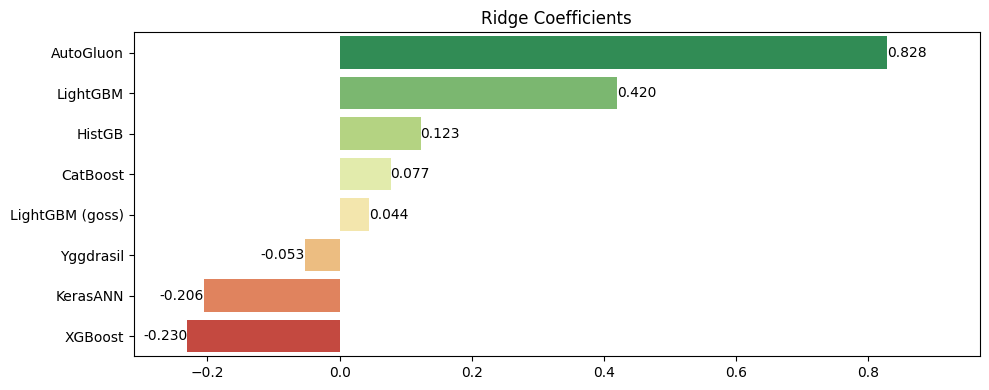

In [27]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [28]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,53.992261
1,750001,18.271845
2,750002,49.250002
3,750003,76.404419
4,750004,48.434825


# Results

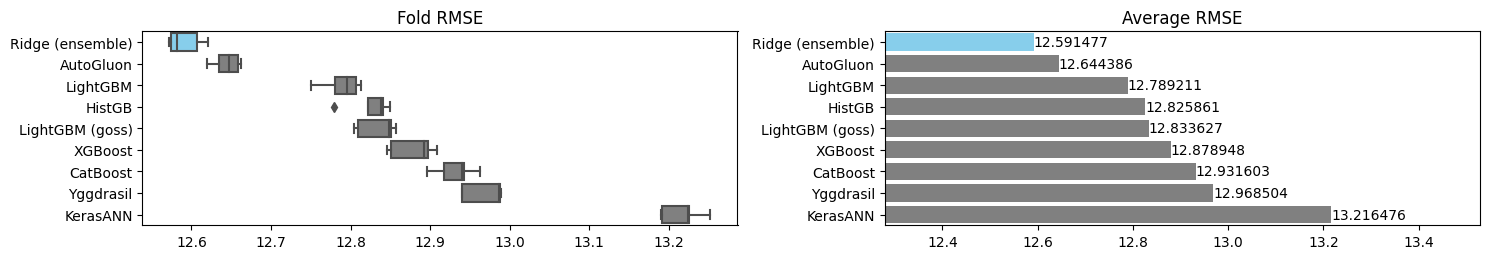

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree("catboost_info", ignore_errors=True)